In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier


In [42]:
df_train = pd.read_csv('df_clean.csv')

In [43]:
exog = ['First_choice', 'Single', 'Application_mode_1st_phase', 'Application_mode_2nd_phase', 'Application_mode_Over_23 years_old',
        'Application_mode_Tech_Spec', 'Application_mode_Change', 'Quali_Secondary education', 'Quali_Basic education', 
        'Quali_Tech Spec course', 'Quali_Higher education', 'Quali_Other', 'Quali_12th year of schooling', 'Quali_Higher education',
        'Quali_Professional higher technical course', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd', 'M_Quali_Basic education_1st',
        'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd',
        'M_Quali_Basic education_1st', 'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'F_Quali_Secondary education',
        'F_Quali_Basic education_3rd', 'F_Quali_Basic education_1st', 'F_Quali_Basic education_2nd', 'F_Quali_Higher Education',
        'Daytime/evening attendance', 'Previous qualification (grade)', 'Admission grade', 'Debtor', 'Tuition fees up to date',
        'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)']

## Logit Model

In [44]:
X_train = df_train[exog]
X_train = sm.add_constant(X_train)

Y_train_g = df_train['Target_Graduate']
Y_train_e = df_train['Target_Enrolled']
Y_train_d = df_train['Target_Dropout']

X_train = X_train.astype(float)

Y_train_g = Y_train_g.astype(float)
Y_train_e = Y_train_e.astype(float)
Y_train_d = Y_train_d.astype(float)

model_g = sm.Logit(Y_train_g, X_train, missing='drop').fit_regularized()
model_e = sm.Logit(Y_train_e, X_train, missing='drop').fit_regularized()
model_d = sm.Logit(Y_train_d, X_train, missing='drop').fit_regularized()

train_pred = pd.DataFrame()
train_pred['Graduate'] = model_g.predict(X_train)
train_pred['Enrolled'] = model_e.predict(X_train)
train_pred['Dropout'] = model_d.predict(X_train)

# print(model.summary())
# np.round(np.mean((model.predict(X_train)>0.5) == df['Target_Enrolled']),4)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.33566021230443616
            Iterations: 266
            Function evaluations: 268
            Gradient evaluations: 266
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40899847348800433
            Iterations: 264
            Function evaluations: 267
            Gradient evaluations: 264
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.25758092864441823
            Iterations: 270
            Function evaluations: 273
            Gradient evaluations: 270


In [45]:
def classify(x):
    if x['Graduate'] > x['Enrolled'] and x['Graduate'] > x['Dropout']:
        return 'Graduate'
    if x['Enrolled'] > x['Graduate'] and x['Enrolled'] > x['Dropout']:
        return 'Enrolled'
    if x['Dropout'] > x['Enrolled'] and x['Dropout'] > x['Graduate']:
        return 'Dropout'
    else:
        return 'Graduate'
    

def target_to_num(x):
    if x['Target'] == 'Graduate':
        return 2
    if x['Target'] == 'Dropout':
        return 0
    if x['Target'] == 'Enrolled':
        return 1
    
def num_to_target(x):
    if x['Target_num'] == 2:
        return 'Graduate'
    if x['Target_num'] == 0:
        return 'Dropout'
    if x['Target_num'] == 1:
        return 'Enrolled'
    

def create_submission(y_pred, df_test, suffix=''):
    data = {'id':df_test['id'],
        'Target_num': y_pred.astype(int)}
    submission = pd.DataFrame(data)
    submission['Target'] = submission.apply(lambda x: num_to_target(x), axis=1)
    submission.drop('Target_num', axis=1, inplace=True)
    submission.to_csv(f'submission{suffix}.csv', index=False)


df_train['Target_num'] = df_train.apply(lambda x: target_to_num(x), axis=1)

In [46]:
train_pred['Target'] = train_pred.apply(lambda x: classify(x), axis=1)
print(np.round(np.mean(train_pred['Target'] == df_train['Target']),4))
print(train_pred.head())

0.7933
   Graduate  Enrolled   Dropout    Target
0  0.915459  0.115757  0.014734  Graduate
1  0.014345  0.190726  0.848248   Dropout
2  0.021586  0.077762  0.892209   Dropout
3  0.964803  0.047911  0.013081  Graduate
4  0.745402  0.229015  0.043680  Graduate


In [47]:
df_test = pd.read_csv('df_clean_test.csv')
X_test = df_test[exog]
X_test = sm.add_constant(X_test)
X_test = X_test.astype(float)

test_pred = pd.DataFrame()
test_pred['Graduate'] = model_g.predict(X_test)
test_pred['Enrolled'] = model_e.predict(X_test)
test_pred['Dropout'] = model_d.predict(X_test)

test_pred['Target'] = test_pred.apply(lambda x: classify(x), axis=1)

submission = pd.DataFrame()
submission['id'] = df_test['id']
submission['Target'] = test_pred['Target']

print(test_pred.head())
submission.to_csv('submission_Logit.csv', index=False)

   Graduate  Enrolled   Dropout    Target
0  0.003010  0.011087  0.981896   Dropout
1  0.753243  0.316973  0.032007  Graduate
2  0.809270  0.125882  0.032804  Graduate
3  0.710388  0.133592  0.053738  Graduate
4  0.130881  0.451527  0.245270  Enrolled


##### Score: 0.79543

## Random Forest

In [48]:
X_train = df_train[exog]
Y_train_num = df_train['Target_num']

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=0, n_jobs=-1)

# param_grid = {"criterion":['gini', 'entropy', 'log_loss'], "min_samples_leaf" : [1, 2, 5], "min_samples_split" : [20], "n_estimators": [100]}

# gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

# gs = gs.fit(X_train, Y_train_num)

# print(gs.best_score_)
# print(gs.best_params_)

In [49]:
clf = RandomForestClassifier(random_state=7, n_estimators=100, min_samples_split=20, min_samples_leaf=2)
clf.fit(X_train, Y_train_num)

y_pred = clf.predict(X_train)

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(Y_train_num, y_pred))
scores = cross_val_score(clf, X_train, Y_train_num, cv=5)
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

ACCURACY OF THE MODEL: 0.8547977752578433
0.8144 accuracy with a standard deviation of 0.0019


In [50]:
df_test = pd.read_csv('df_clean_test.csv')
X_test = df_test[exog]

y_pred = clf.predict(X_test)

create_submission(y_pred, df_test, '_rf')

##### Score: 0.81768

## K-NN Classification

In [51]:
exog = ['Previous qualification (grade)', 'Admission grade', 'Debtor', 'Tuition fees up to date',
        'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)']

X_train_knn = X_train[exog]
X_test_knn = X_test[exog]

scaler = StandardScaler()
X_train_knn = scaler.fit(X_train_knn).transform(X_train_knn)
X_test_knn = scaler.fit(X_test_knn).transform(X_test_knn)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_knn, Y_train_num, test_size=0.2, random_state=0)

In [52]:
clf = KNeighborsClassifier(leaf_size=2, algorithm='auto', n_neighbors=5)
clf.fit(X_train, Y_train)
print(clf.score(X_valid, Y_valid))
y_pred = clf.predict(X_test_knn)

scores = cross_val_score(clf, X_train, Y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

create_submission(y_pred, df_test, '_knn')

0.7874595032397408
0.79 accuracy with a standard deviation of 0.00


## XGBoost

In [53]:
exog = ['First_choice', 'Single', 'Application_mode_1st_phase', 'Application_mode_2nd_phase', 'Application_mode_Over_23 years_old',
        'Application_mode_Tech_Spec', 'Application_mode_Change', 'Quali_Secondary education', 'Quali_Basic education', 
        'Quali_Tech Spec course', 'Quali_Higher education', 'Quali_Other', 'Quali_12th year of schooling', 'Quali_Higher education',
        'Quali_Professional higher technical course', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd', 'M_Quali_Basic education_1st',
        'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd',
        'M_Quali_Basic education_1st', 'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'F_Quali_Secondary education',
        'F_Quali_Basic education_3rd', 'F_Quali_Basic education_1st', 'F_Quali_Basic education_2nd', 'F_Quali_Higher Education',
        'Daytime/evening attendance', 'Previous qualification (grade)', 'Admission grade', 'Debtor', 'Tuition fees up to date',
        'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)']


X_train = df_train[exog]
Y_train_num = df_train['Target_num']

X_train_std = X_train[exog]
X_test_std = X_test[exog]

scaler = StandardScaler()
X_train_std = scaler.fit(X_train_knn).transform(X_train_knn)
X_test_std = scaler.fit(X_test_knn).transform(X_test_knn)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_knn, Y_train_num, test_size=0.2, random_state=0)

In [54]:
model1 = XGBClassifier(n_estimators=100, learning_rate=0.01)
model1.fit(X_train, Y_train,
             eval_set=[(X_valid, Y_valid)], 
             verbose=False)

predictions = model1.predict(X_valid)
predictions

scores = cross_val_score(model1, X_train, Y_train, cv=10)
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.8116 accuracy with a standard deviation of 0.0065


In [55]:
y_pred = model1.predict(X_test_std)

In [56]:
create_submission(y_pred, df_test, suffix='_xgb')

## MLP Classifier

In [57]:
exog = ['First_choice', 'Single', 'Application_mode_1st_phase', 'Application_mode_2nd_phase', 'Application_mode_Over_23 years_old',
        'Application_mode_Tech_Spec', 'Application_mode_Change', 'Quali_Secondary education', 'Quali_Basic education', 
        'Quali_Tech Spec course', 'Quali_Higher education', 'Quali_Other', 'Quali_12th year of schooling', 'Quali_Higher education',
        'Quali_Professional higher technical course', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd', 'M_Quali_Basic education_1st',
        'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd',
        'M_Quali_Basic education_1st', 'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'F_Quali_Secondary education',
        'F_Quali_Basic education_3rd', 'F_Quali_Basic education_1st', 'F_Quali_Basic education_2nd', 'F_Quali_Higher Education',
        'Daytime/evening attendance', 'Previous qualification (grade)', 'Admission grade', 'Debtor', 'Tuition fees up to date',
        'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)']

df_train = pd.read_csv('df_clean.csv')
df_train['Target_num'] = df_train.apply(lambda x: target_to_num(x), axis=1)

X_train = df_train[exog]
Y_train_num = df_train['Target_num']

X_train_std = X_train[exog]
X_test_std = X_test[exog]

scaler = StandardScaler()
X_train_std = scaler.fit(X_train_knn).transform(X_train_knn)
X_test_std = scaler.fit(X_test_knn).transform(X_test_knn)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_knn, Y_train_num, test_size=0.2, random_state=0)

In [58]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=[16, 16], max_iter=10000, verbose=True).fit(X_train, Y_train)

clf.score(X_train, Y_train)

Iteration 1, loss = 0.63479990
Iteration 2, loss = 0.51736210
Iteration 3, loss = 0.50480733
Iteration 4, loss = 0.49902223
Iteration 5, loss = 0.49612705
Iteration 6, loss = 0.49440313
Iteration 7, loss = 0.49333277
Iteration 8, loss = 0.49274508
Iteration 9, loss = 0.49202531
Iteration 10, loss = 0.49184533
Iteration 11, loss = 0.49124431
Iteration 12, loss = 0.49101416
Iteration 13, loss = 0.49064927
Iteration 14, loss = 0.49040772
Iteration 15, loss = 0.49016217
Iteration 16, loss = 0.48974863
Iteration 17, loss = 0.48966954
Iteration 18, loss = 0.48933073
Iteration 19, loss = 0.48914231
Iteration 20, loss = 0.48863994
Iteration 21, loss = 0.48867865
Iteration 22, loss = 0.48823928
Iteration 23, loss = 0.48854290
Iteration 24, loss = 0.48800748
Iteration 25, loss = 0.48793595
Iteration 26, loss = 0.48774693
Iteration 27, loss = 0.48742725
Iteration 28, loss = 0.48744166
Iteration 29, loss = 0.48730890
Iteration 30, loss = 0.48708470
Iteration 31, loss = 0.48696752
Iteration 32, los

0.8132635842051974

## Mutual Information Ratio

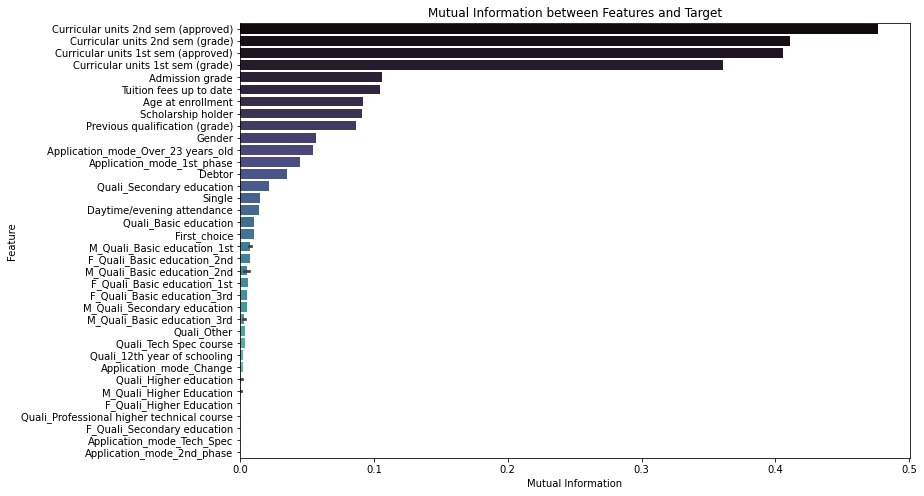

In [59]:
exog = ['First_choice', 'Single', 'Application_mode_1st_phase', 'Application_mode_2nd_phase', 'Application_mode_Over_23 years_old',
        'Application_mode_Tech_Spec', 'Application_mode_Change', 'Quali_Secondary education', 'Quali_Basic education', 
        'Quali_Tech Spec course', 'Quali_Higher education', 'Quali_Other', 'Quali_12th year of schooling', 'Quali_Higher education',
        'Quali_Professional higher technical course', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd', 'M_Quali_Basic education_1st',
        'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'M_Quali_Secondary education', 'M_Quali_Basic education_3rd',
        'M_Quali_Basic education_1st', 'M_Quali_Basic education_2nd', 'M_Quali_Higher Education', 'F_Quali_Secondary education',
        'F_Quali_Basic education_3rd', 'F_Quali_Basic education_1st', 'F_Quali_Basic education_2nd', 'F_Quali_Higher Education',
        'Daytime/evening attendance', 'Previous qualification (grade)', 'Admission grade', 'Debtor', 'Tuition fees up to date',
        'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)']

df_train['Target'] = df_train['Target'].astype('category').cat.codes
df = df_train

features = df.drop('Target', axis=1)
target = df['Target']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X = df[exog]
y = df['Target']

mi = mutual_info_classif(X, y)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
})

mi_df.sort_values(by='Mutual Information', ascending = False, inplace = True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='mako')
plt.title('Mutual Information between Features and Target')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.show()

In [60]:
exog = mi_df.nlargest(12, columns='Mutual Information')['Feature'].tolist()

X = df[exog]
y = df['Target']

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=0, n_jobs=-1)

clf = RandomForestClassifier(random_state=7, n_estimators=100, min_samples_split=20, min_samples_leaf=2)
clf.fit(X, y)

y_pred = clf.predict(X)

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y, y_pred))
scores = cross_val_score(clf, X, y, cv=5)
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

ACCURACY OF THE MODEL: 0.8535153086019763
0.8138 accuracy with a standard deviation of 0.0016
